In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from scipy.integrate import quad, quad_explain
from scipy.stats import binned_statistic
import camb

%matplotlib inline

In [2]:
# for plots
import seaborn as sns
sns.set_style("ticks", {'axes.grid': True, 'grid.linestyle': '--'})
sns.set_context("poster")
sns.set_palette("Set2")

In [3]:
# cosmology
pars = camb.CAMBparams()

In [4]:
# planck 2015 TT+lowP+lensing
# https://www.aanda.org/articles/aa/full_html/2016/10/aa25830-15/aa25830-15.html
pars.set_cosmology(ombh2=0.02226, 
                   omch2=0.1186,
                   cosmomc_theta=1.04103/100,
                   H0 = None,
                   tau = 0.066)

pars.InitPower.set_params(ns=0.9677,
                          As=2.139e-9)

pars.set_matter_power(redshifts=[0])

#results
results = camb.get_results(pars)

In [5]:
# use these two lines to compare with Planck derived parameters (Table 4 of 2015 parameters
# paper)
# results.get_derived_params()
# results.get_sigma8()

In [21]:
# linear matter power spectrum
kmin = 0.001
kmax = 100.
# multiplicative factors to make sure the region between kmin and kmax is properly interpolated
kh, z, [pk] = results.get_matter_power_spectrum(minkh=kmin*0.99, maxkh=kmax*1.001,npoints=1000)
# creating a P(k) function by interpolating camb output
pk_k = interpolate.interp1d(kh,pk, kind='cubic')

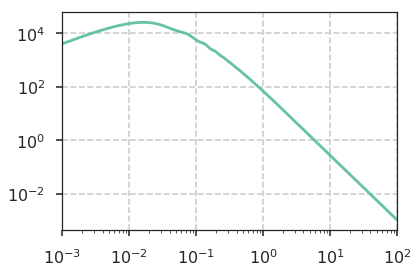

In [25]:
plt.loglog(kh, pk_k(kh))
plt.xlim(kmin,kmax)
plt.show()

In [113]:
# correlation function
def xi(r,kmin=kmin,kmax=kmax,pk=pk_k):
    # sin is omitted in the integrand because its being weighted in quad
    int_ = lambda k: k**2 * pk(k)/(2*(np.pi**2)*k*r)
    xir =  quad(int_,kmin, kmax,weight='sin', wvar=r)
    return xir[0]

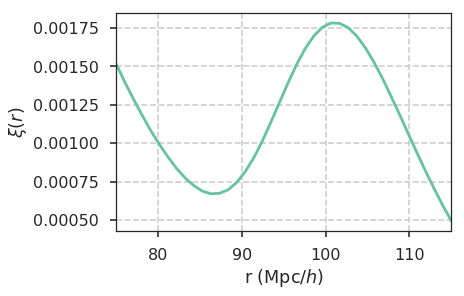

In [115]:
r = np.linspace(75,115,40)
xi_r = [xi(i, kmin,kmax, pk_k) for i in r]

plt.plot(r, xi_r, label=r'$\xi(r)$')
#plt.plot(*xi_binned(r,xi_r), label=r'$\xi(r)$ binned')

#plt.ylim(-0.001,0.004)
plt.xlim(r.min(),r.max())
#plt.legend()

plt.ylabel(r'$\xi(r)$')
plt.xlabel(r'r (${\rm Mpc}/h$)')

# plt.savefig('Figures/xi_r.png', dpi=300, bbox_inches='tight',
#            facecolor='w', edgecolor='w')
plt.show()